<a href="https://colab.research.google.com/github/aloncohen1/ydata_deep_learning_2021/blob/main/semester_2/deep_learning/HW5/DL_word_embedding_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Embedding - Home Assigment
## Dr. Omri Allouche 2021. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/ydata_deep_learning_2021/blob/master/assignments/word_vectors_text_classification/DL_word_embedding_assignment.ipynb)

    
In this exercise, you'll use word vectors trained on a corpus of lyrics of songs from MetroLyrics ([http://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet](/data/metrolyrics.parquet)).
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [2]:
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')

df = pd.read_parquet("https://raw.githubusercontent.com/omriallouche/ydata_deep_learning_2021/master/data/metrolyrics.parquet")
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,song,year,artist,genre,lyrics,num_chars,sent,num_words
204182,fully-dressed,2008,annie,Pop,[HEALY]\n[spoken] This is Bert Healy saying .....,1041,healy spoken this bert healy saying singing he...,826
6116,surrounded-by-hoes,2006,50-cent,Hip-Hop,[Chorus: repeat 2X] Even when I'm tryin to be ...,1392,chorus repeat x even i tryin low i recognized ...,884
166369,taste-the-tears-thunderpuss-remix,2006,amber,Pop,How could you cause me so much pain?\nAnd leav...,1113,how could cause much pain and leave heart rain...,756
198416,the-truth-will-set-me-free,2006,glenn-hughes,Rock,In a scarlet vision\nIn a velvet room\nI come ...,779,in scarlet vision in velvet room i come decisi...,583
127800,the-last-goodbye,2008,aaron-pritchett,Country,Sprintime in Savannah\nIt dont get much pretti...,881,sprintime savannah it dont get much prettier b...,639


In [22]:
all_words_list = set()

def process_text(text):

  text = word_tokenize(re.sub("[^A-Za-z']+", ' ', str(text))).lower() # lowercasing and tokenization
  text = [word.translate(str.maketrans('', '', string.punctuation)).strip() for word in text] # remove punctuation
  text = [word for word in text if word not in stopwords.words('english') and word is not ''] # remove stopwords

  all_words_list.update(set(text))

  return ' '.join(text)


df['clean_lyrics'] = df.apply(lambda x: process_text(x['lyrics']), axis=1)

In [30]:
sent = [row.split() for row in df['clean_lyrics']]

In [35]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(sent, min_count=30, progress_per=10000)

In [37]:
bigram = Phraser(phrases)
sentences = bigram[sent]

In [40]:
from time import time

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.45 mins


In [41]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 25.23 mins


In [42]:
w2v_model.save('w2v_model.model')

In [1]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load("w2v_model.model")

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [9]:
print(w2v_model.wv.most_similar('mother',topn=3))
print(w2v_model.wv.most_similar('joke',topn=3))
print(w2v_model.wv.most_similar('stop',topn=3))

[('father', 0.48190930485725403), ('brother', 0.41736847162246704), ('child', 0.39826399087905884)]
[('broke', 0.36072659492492676), ('funny', 0.3560766279697418), ('comedian', 0.2867908179759979)]
[('cause', 0.5850833058357239), ('keep', 0.5623694658279419), ('know', 0.5231946110725403)]


### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [13]:
print(w2v_model.wv.most_similar(positive=["mother", "man"], negative=["woman"], topn=3))
print(w2v_model.wv.most_similar(positive=["father", "woman"], negative=["man"], topn=3))
print(w2v_model.wv.most_similar(positive=["king", "woman"], negative=["man"], topn=3))

[('brother', 0.4154040217399597), ('fuck', 0.39607614278793335), ('shit', 0.3740338385105133)]
[('mother', 0.34044840931892395), ('father_father', 0.33039313554763794), ('grace', 0.3256756365299225)]
[('queen', 0.3891682028770447), ('martin_luther', 0.3173820376396179), ('princess', 0.3081028163433075)]


## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [93]:
# get data
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen


sentiments_list = []

resp = urlopen(download_url)
zipfile = ZipFile(BytesIO(resp.read()))
file_name = zipfile.namelist()[-1]

negators = zipfile.namelist()[-2]
negators = zipfile.open(negators).readlines()
negators = [line.decode('utf-8').split()[0] for line in negators]

for line in zipfile.open(file_name).readlines():
  line = line.decode('utf-8').replace('#','').split()
  score = float(line[0])
  text = ' '.join(line[1:]).strip()
  word_a = text.split()[0]
  word_b = text.split()[1] if len(line) > 2 else None
  
  sentiments_list.append({'score': score,
                          'text':text,
                          'word_a':word_a,
                          'word_b':word_b})

In [96]:
# parse data
sentiment_df = pd.DataFrame(sentiments_list)
sentiment_df['words_for_train'] = sentiment_df.apply(lambda x: x['word_b'] if x['word_b'] else x['word_a'],axis=1)
sentiment_df['isin_vocab'] = sentiment_df.apply(lambda x: x['words_for_train'] in w2v_model.wv.vocab.keys(),axis=1)
sentiment_df = sentiment_df[sentiment_df['isin_vocab']]
sentiment_df['has_negators'] = sentiment_df.apply(lambda x: x['word_a'] in negators if x['word_b'] else False,axis=1)

sentiment_df['word_v'] = sentiment_df.apply(lambda x: w2v_model.wv.get_vector(x['words_for_train']),axis=1)
sentiment_df.head()

,score,text,word_a,word_b,words_for_train,isin_vocab,has_negators,word_v
0,0.984,loves,loves,None,loves,True,False,"[0.039917566, -0.19262722, -1.5087744, -0.6006..."
2,0.969,amazing,amazing,None,amazing,True,False,"[-1.1648709, -0.28753403, -0.4908852, -0.99061..."
3,0.969,peaceful,peaceful,None,peaceful,True,False,"[-0.023836747, -0.476886, -0.22323118, -1.2462..."
4,0.953,greatness,greatness,None,greatness,True,False,"[1.0555886, -1.1125934, -0.05948353, -1.023635..."
5,0.938,fantastic,fantastic,None,fantastic,True,False,"[-0.29725134, 0.38916177, -0.21154138, 1.04324..."


In [139]:
#train model
from sklearn.model_selection import train_test_split
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(sentiment_df['word_v'].apply(pd.Series), 
                                                    sentiment_df['score'], 
                                                    test_size=0.33, 
                                                    random_state=42)

clf = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
                       learning_rate = 0.1,
                       max_depth = 5,
                       alpha = 10,
                       n_estimators = 10)

clf.fit(X_train,y_train)
preds = clf.predict(X_test)

preds_df = pd.DataFrame(zip(preds, y_test, y_test.index),columns=['preds','actual','index'])
preds_df = preds_df.merge(sentiment_df['has_negators'],left_on=['index'],right_index=True,how='left')
# preds_df.loc[preds_df["has_negators"], "preds"] *=-1.0

preds_df.head()

[21:52:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,preds,actual,index,has_negators
0,0.201677,0.266,493,False
1,0.059057,-0.172,937,False
2,0.324986,0.172,601,False
3,0.194144,-0.328,1068,True
4,0.266613,0.406,380,False


correlation - 0.3532873029514073
mean_absolute_error - 0.3825378084156467


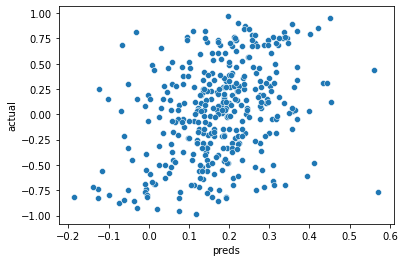

In [142]:
from sklearn.metrics import mean_absolute_error

sns.scatterplot(data=preds_df,x='preds',y='actual');
print('correlation - %s' % preds_df[['preds','actual']].corr().loc['actual','preds']);
print('mean_absolute_error - %s' % mean_absolute_error(preds_df['preds'],preds_df['actual']))

Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

Show the confusion matrix.

Show the classification report - precision, recall, f1 for each class.

### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.